# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

pip install statsmodels

pip install pmdarima

pip install --user optuna

### Initialization

In [1]:
import pandas as pd
import time
import seaborn as sns
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import numpy as np
from sklearn.svm import SVR
from scipy import signal

from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
import optuna
from sklearn.ensemble import StackingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler


import statsmodels.api as sm

from sklearn.model_selection import RandomizedSearchCV

/opt/conda/envs/python3/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: ping-extensions is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
data=pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])

In [ ]:
# Ensuring the index is a DatetimeIndex
data.index = pd.to_datetime(data.index)

# Resample and sum the 'num_orders'
data = data['num_orders'].resample('H').sum().to_frame()

# Extracting features
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6])
data['hour'] = data.index.hour
data['month'] = data.index.month

# Checking the result
print(data.head())

                     num_orders  day_of_week  is_weekend  hour  month
datetime                                                             
2018-03-01 00:00:00         124            3       False     0      3
2018-03-01 01:00:00          85            3       False     1      3
2018-03-01 02:00:00          71            3       False     2      3
2018-03-01 03:00:00          66            3       False     3      3
2018-03-01 04:00:00          43            3       False     4      3


### EDA

In [4]:
data.head(10)

,num_orders,day_of_week,is_weekend,hour,month
datetime,,,,,
2018-03-01 00:00:00,124,3,False,0,3
2018-03-01 01:00:00,85,3,False,1,3
2018-03-01 02:00:00,71,3,False,2,3
2018-03-01 03:00:00,66,3,False,3,3
2018-03-01 04:00:00,43,3,False,4,3
2018-03-01 05:00:00,6,3,False,5,3
2018-03-01 06:00:00,12,3,False,6,3
2018-03-01 07:00:00,15,3,False,7,3
2018-03-01 08:00:00,34,3,False,8,3


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   num_orders   4416 non-null   int64
 1   day_of_week  4416 non-null   int64
 2   is_weekend   4416 non-null   bool 
 3   hour         4416 non-null   int64
 4   month        4416 non-null   int64
dtypes: bool(1), int64(4)
memory usage: 176.8 KB


In [6]:
data.describe()

,num_orders,day_of_week,hour,month
count,4416.000000,4416.000000,4416.00000,4416.000000
mean,84.422781,3.005435,11.50000,5.505435
std,45.023853,1.990684,6.92297,1.713306
min,0.000000,0.000000,0.00000,3.000000
25%,54.000000,1.000000,5.75000,4.000000
50%,78.000000,3.000000,11.50000,5.500000
75%,107.000000,5.000000,17.25000,7.000000
max,462.000000,6.000000,23.00000,8.000000


In [7]:
data.isnull().sum()

num_orders     0
day_of_week    0
is_weekend     0
hour           0
month          0
dtype: int64

In [8]:
data.duplicated().sum()

118

## Analysis

<AxesSubplot:title={'center':'Number of Orders'}, ylabel='Frequency'>

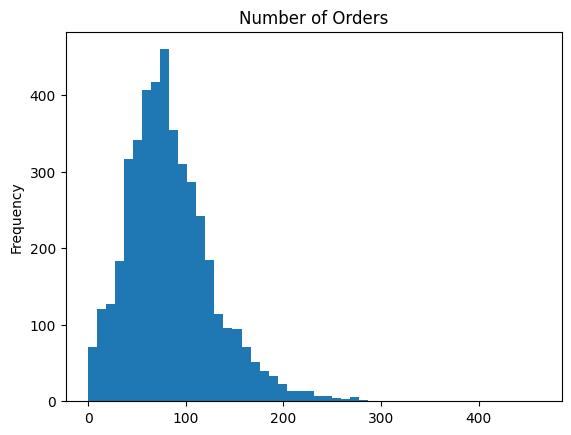

In [9]:
data['num_orders'].plot(kind='hist',bins=50,title='Number of Orders')

Skewed Distribution: The distribution is right-skewed, with the majority of orders centered around lower values.
Most Orders are Low: A large portion of the data falls below 20 orders, indicating that high-order counts are less frequent.
Outliers: There are some outliers with a significantly higher number of orders, but these are rare.
Typical Order Range: Most orders occur between 0 and 30, which might represent typical consumer behavior.

In [10]:
data.sort_index(inplace=True)
print(data.index.is_monotonic)
print(data.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   num_orders   4416 non-null   int64
 1   day_of_week  4416 non-null   int64
 2   is_weekend   4416 non-null   bool 
 3   hour         4416 non-null   int64
 4   month        4416 non-null   int64
dtypes: bool(1), int64(4)
memory usage: 176.8 KB
None


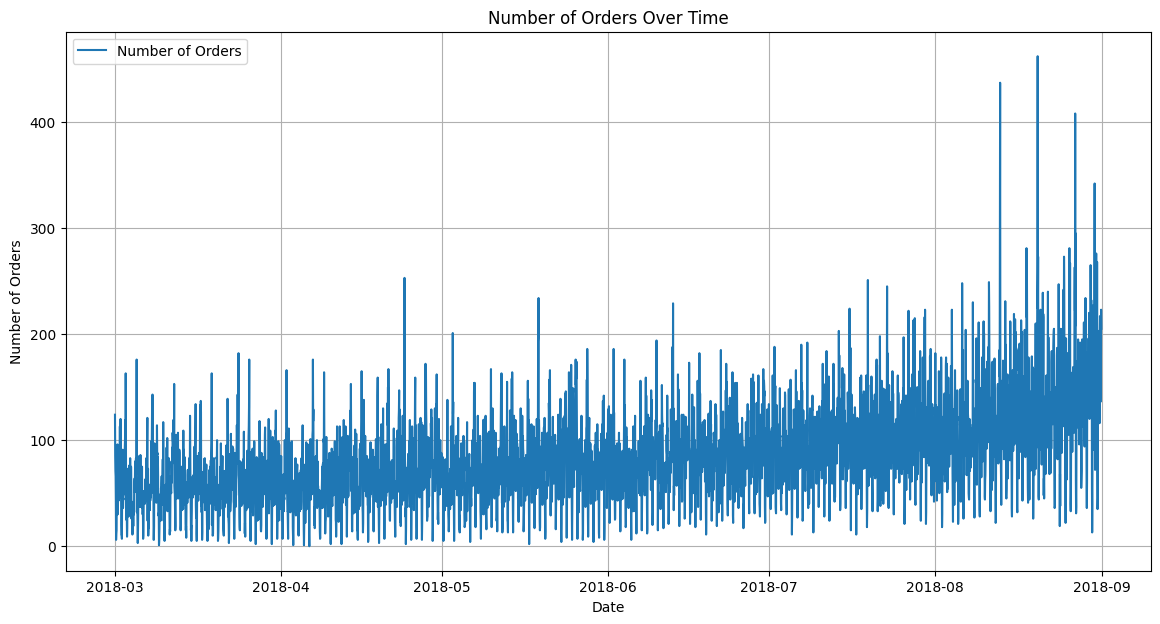

In [11]:
# Plotting the time series
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['num_orders'], label='Number of Orders')
plt.title('Number of Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

Trend: There is an upward trend in the data, indicating an increase in the number of orders over time.

Volatility: There are fluctuations and spikes, which suggest variability in daily orders. This may reflect periods of promotions or special events.

Seasonality: There doesn't appear to be a clear seasonal pattern, but you might want to further investigate for any weekly or monthly seasonality.

Growth Opportunity: The increasing trend suggests potential growth, which may imply that strategies focusing on scaling operations could be beneficial.

Potential Anomalies: Some extreme spikes could indicate unusual events or errors that might need further exploration.


### Orders By Month

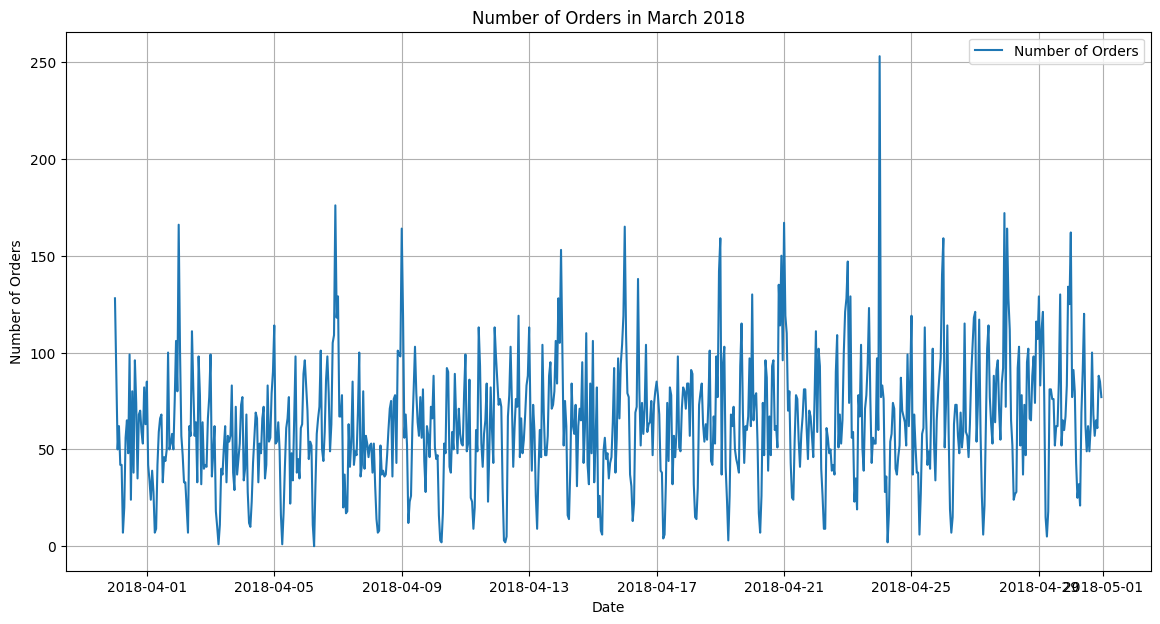

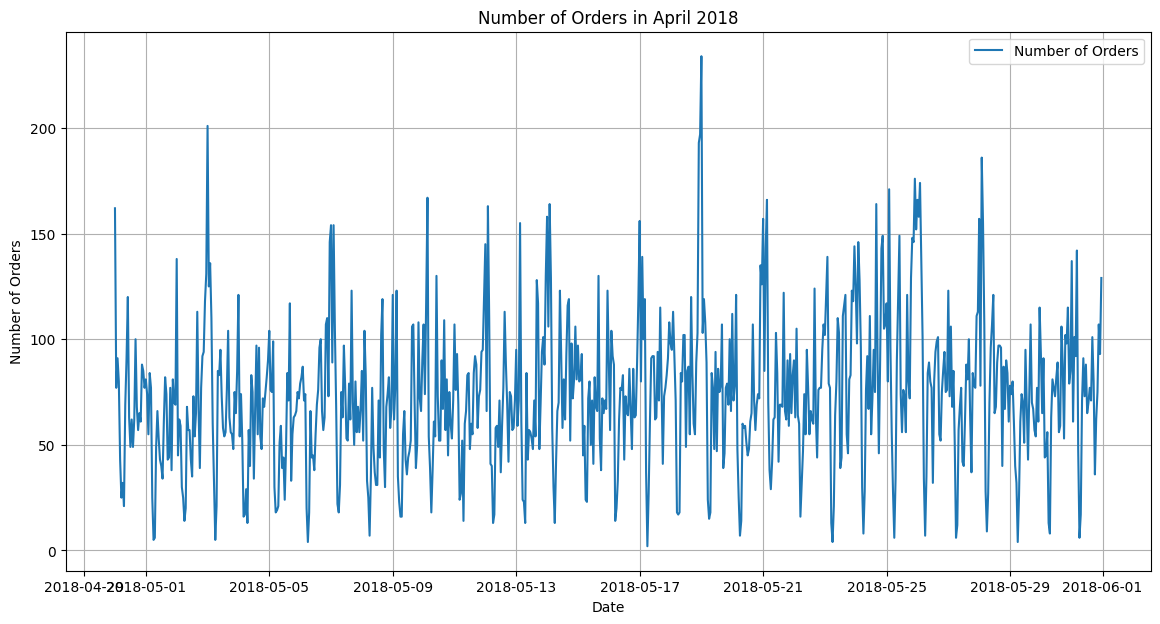

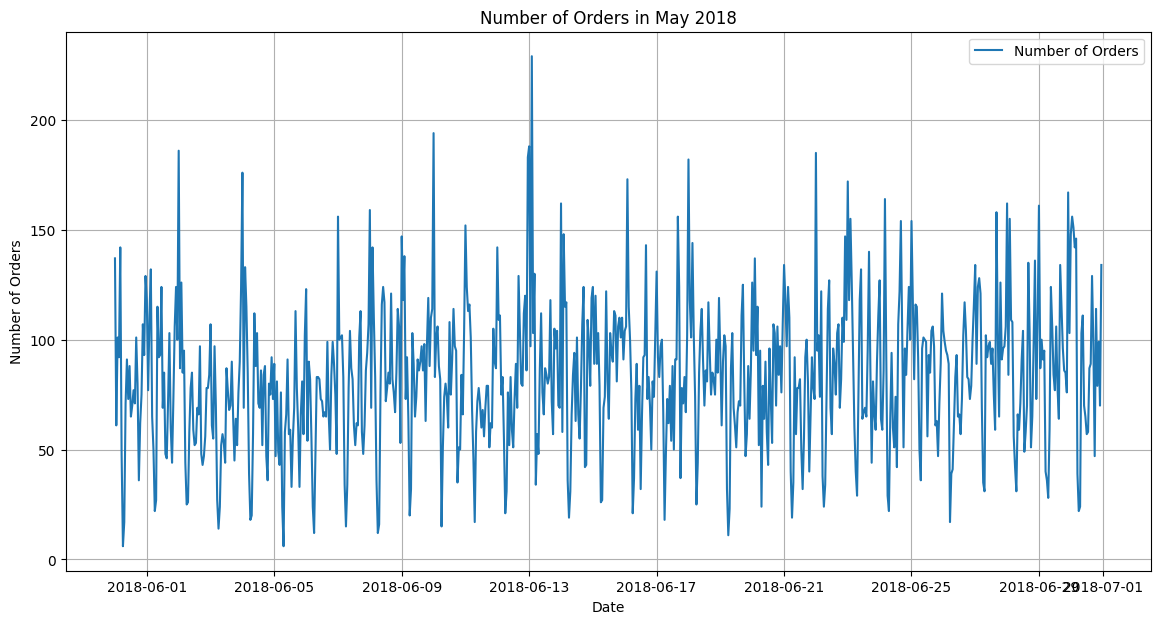

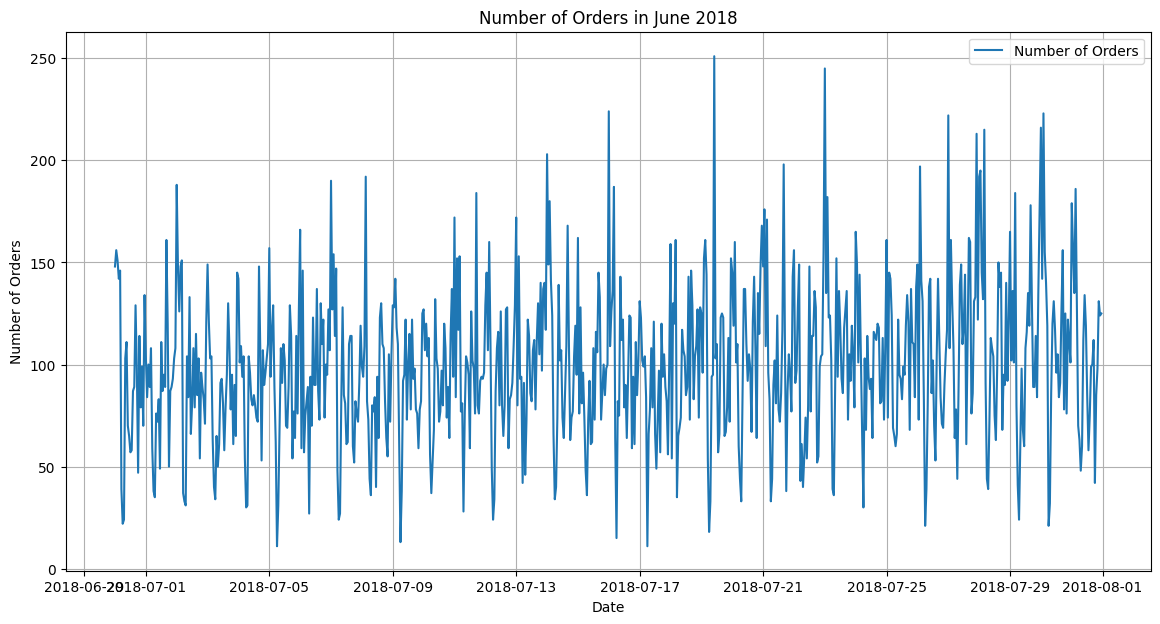

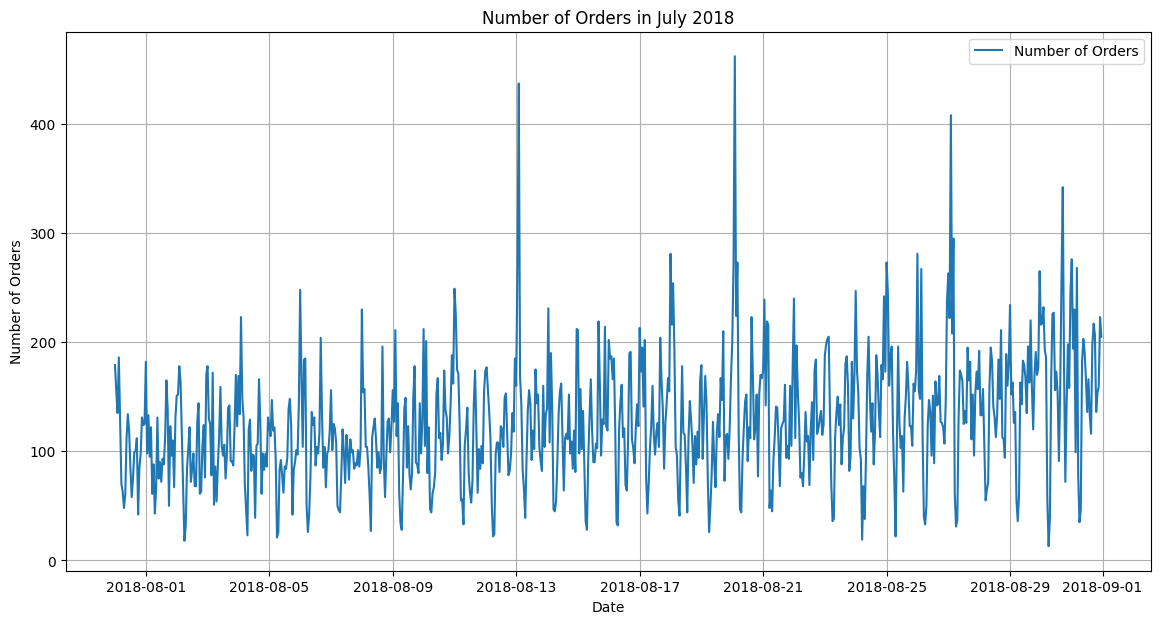

In [12]:
months = pd.date_range(start='2018-03', end='2018-09', freq='M')

for i in range(len(months)-1):
    start_date = months[i].strftime('%Y-%m-%d')
    end_date = months[i+1].strftime('%Y-%m-%d')
    month_name = months[i].strftime('%B %Y')
    
    filtered_data = data.loc[start_date:end_date]
    
    plt.figure(figsize=(14, 7))
    plt.plot(filtered_data.index, filtered_data['num_orders'], label='Number of Orders')
    plt.title(f'Number of Orders in {month_name}')
    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.legend()
    plt.grid(True)
    plt.show()


Daily Variability: There is significant variability in the number of daily orders.

Peak Days: Some days exhibit noticeable spikes, which may indicate special events or promotions.

Lack of Clear Pattern: There isn’t an obvious weekly pattern, but there might be minor cycles. Further analysis could explore specific days for trends.

Potential Anomalies: Occasional extreme values suggest anomalies that could be investigated for quality checks or special causes.

General Consistency: Despite fluctuations, most days stay within a consistent range.


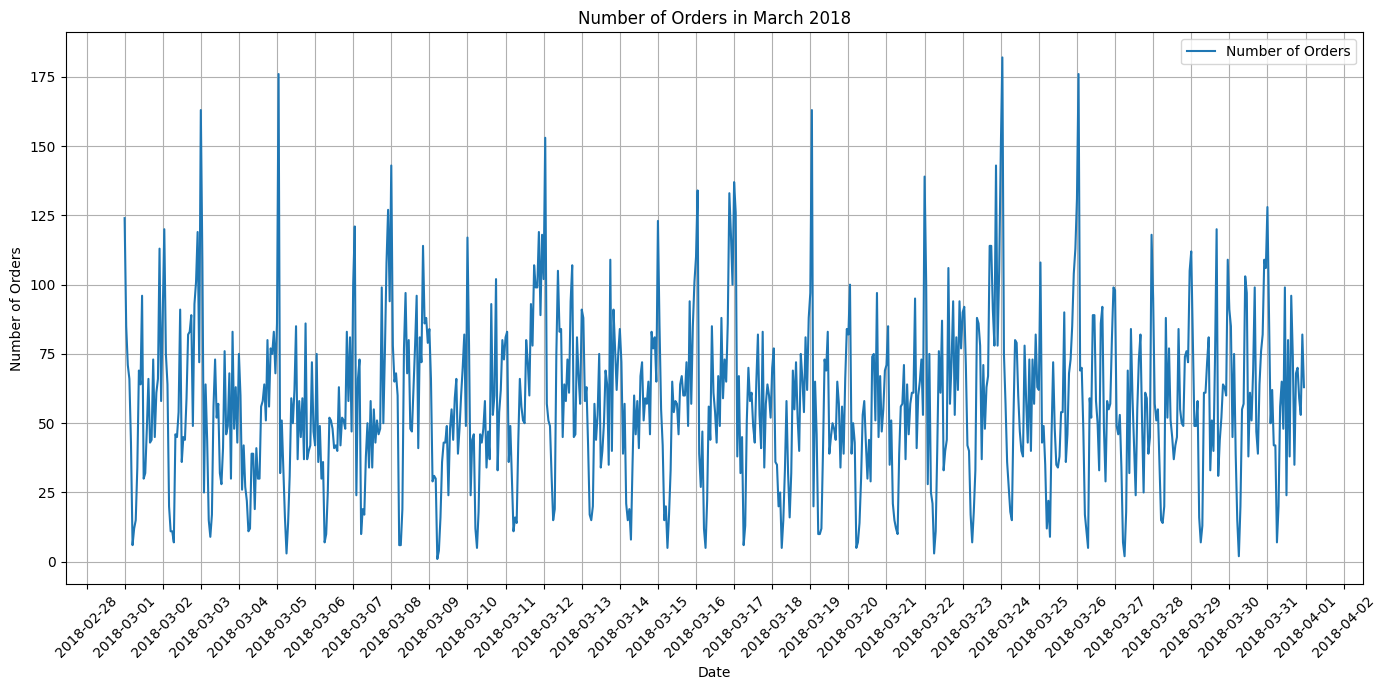

In [13]:
# Example filtering for a specific month
start_date = '2018-03-01'
end_date = '2018-03-31'
filtered_data = data.loc[start_date:end_date]

# Plot
plt.figure(figsize=(14, 7))
plt.plot(filtered_data.index, filtered_data['num_orders'], label='Number of Orders')
plt.title('Number of Orders in March 2018')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)

# Set x-axis major ticks as days
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate date labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Consistency: The number of orders remains fairly consistent each day, with most fluctuations within a similar range.

Few Peaks: There are occasional peaks, indicating higher order days, possibly due to promotions or events.

Daily Variations: Variations occur daily, but there is no strong indication of weekly patterns.

Anomalies: Some outlier days with high order numbers could represent special circumstances or data errors.

Operational Planning: Understanding these patterns can assist in staffing or inventory requirements.


### Statistics

In [ ]:
mean_orders = data['num_orders'].mean()
median_orders = data['num_orders'].median()
mode_orders = data['num_orders'].mode()[0] 
std_orders = data['num_orders'].std()
range_orders = data['num_orders'].max() - data['num_orders'].min()

print(f"Mean: {mean_orders}")
print(f"Median: {median_orders}")
print(f"Mode: {mode_orders}")
print(f"Standard Deviation: {std_orders}")
print(f"Range: {range_orders}")

Mean: 84.42278079710145
Median: 78.0
Mode: 73
Standard Deviation: 45.023853419354026
Range: 462


In [ ]:
# Filter the data for the last month
last_month_start = '2018-08-01'
last_month_end = '2018-08-31'
last_month_data = data.loc[last_month_start:last_month_end]

# Calculate statistics for the last month
mean_orders = last_month_data['num_orders'].mean()
median_orders = last_month_data['num_orders'].median()
mode_orders = last_month_data['num_orders'].mode()[0]
std_orders = last_month_data['num_orders'].std()
range_orders = last_month_data['num_orders'].max() - last_month_data['num_orders'].min()

print(f"Mean: {mean_orders}")
print(f"Median: {median_orders}")
print(f"Mode: {mode_orders}")
print(f"Standard Deviation: {std_orders}")
print(f"Range: {range_orders}")

# Calculate IQR for the last month
Q1 = last_month_data['num_orders'].quantile(0.25)
Q3 = last_month_data['num_orders'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = last_month_data[(last_month_data['num_orders'] < lower_bound) | (last_month_data['num_orders'] > upper_bound)]

print(f"Number of Outliers: {len(outliers)}")

Mean: 127.65188172043011
Median: 122.0
Mode: 122
Standard Deviation: 56.242227964528446
Range: 449
Number of Outliers: 15


                  mean  median        std  mode  range
datetime                                              
2018-03-31   57.483871      55  29.562439    57    181
2018-04-30   63.804167      61  32.036301    53    253
2018-05-31   73.682796      71  34.849825    77    232
2018-06-30   83.202778      83  32.826776    69    223
2018-07-31  100.006720      98  37.254770   104    240
2018-08-31  127.651882     122  56.242228   122    449


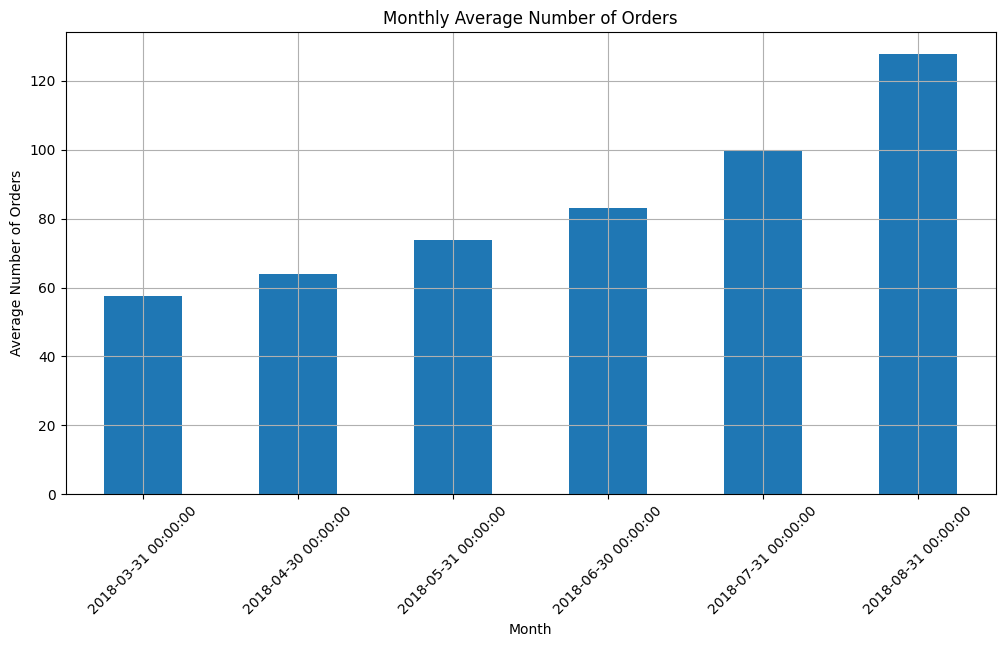

In [16]:
# Calculate monthly statistics
monthly_stats = data['num_orders'].resample('M').agg(['mean', 'median', 'std'])
monthly_stats['mode'] = data['num_orders'].resample('M').apply(lambda x: x.mode()[0])
monthly_stats['range'] = data['num_orders'].resample('M').apply(lambda x: x.max() - x.min())

# Display the results
print(monthly_stats)

# Plot the monthly means
monthly_stats['mean'].plot(kind='bar', figsize=(12, 6), title='Monthly Average Number of Orders')
plt.xlabel('Month')
plt.ylabel('Average Number of Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Upward Trend: There’s a gradual increase in the average number of orders over the months, indicating growth in demand.

Sustained Growth: The increase is consistent each month, suggesting reliable growth rather than seasonal spikes.

Strategic Planning: The consistent rise supports expanding operations or inventory to accommodate increasing demand.

Performance Monitoring: It's crucial to maintain this upward momentum, possibly by analyzing factors driving the growth.

### Outliers

In [17]:
# Calculate IQR
#Q1 = data['num_orders'].quantile(0.25)
#Q3 = data['num_orders'].quantile(0.75)
#IQR = Q3 - Q1

# Define outliers
#lower_bound = Q1 - 1.5 * IQR
#upper_bound = Q3 + 1.5 * IQR

#outliers = data[(data['num_orders'] < lower_bound) | (data['num_orders'] > upper_bound)]

#print(f"Number of Outliers: {len(outliers)}")

In [18]:
# Function to find outliers using standard deviation
#def find_outliers_std(group):
    #mean = group.mean()
    #std = group.std()
    #lower_bound = mean - 2 * std
    #upper_bound = mean + 2 * std
    #return group[(group < lower_bound) | (group > upper_bound)]

# Apply the function to each month's data
#monthly_outliers = data['num_orders'].resample('M').apply(find_outliers_std)

# Display the results
#for month, outliers in monthly_outliers.groupby(level=0):
    #print(f"Month: {month.strftime('%Y-%m')} - Number of Outliers: {len(outliers)}")
    #print(outliers)

Monthly Variation: The number of outliers varies each month, with different counts seen in March through August.

Decreasing Trend: Outlier counts generally decrease from March to August, suggesting better data stability over time.

Outlier Analysis: High order counts at specific hours may pinpoint unusual demand, possibly due to special events or promotions.

Operational Insights: Identify these peak times for resource allocation or deeper investigation, especially where outliers are frequent.

Data Quality Check: Explore why outliers occur and whether they indicate data inconsistencies or valid business events.


### Transformation

In [19]:
#data['num_orders_log'] = np.log1p(data['num_orders'])

### Dropping outliers

In [20]:
# Remove outliers
data = data[(data['num_orders'] >= lower_bound) & (data['num_orders'] <= upper_bound)]   

### Correlation

In [21]:
correlation_matrix = data.corr()
print(correlation_matrix['num_orders'])

num_orders     1.000000
day_of_week   -0.011595
is_weekend    -0.041719
hour           0.023955
month          0.511437
Name: num_orders, dtype: float64


#### Event Impact

#Example for a hypothetical event period
event_start = '2018-07-01'
event_end = '2018-07-07'

before_event = data['num_orders'].loc[:event_start].mean()
during_event = data['num_orders'].loc[event_start:event_end].mean()
after_event = data['num_orders'].loc[event_end:].mean()

print(f"Average before event: {before_event}")
print(f"Average during event: {during_event}")
print(f"Average after event: {after_event}")

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['num_orders'], label='Number of Orders')
plt.axvspan(event_start, event_end, color='red', alpha=0.3, label='Event Period')
plt.title('Number of Orders with Event Highlighted')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
data

,num_orders,day_of_week,is_weekend,hour,month
datetime,,,,,
2018-03-01 00:00:00,124,3,False,0,3
2018-03-01 01:00:00,85,3,False,1,3
2018-03-01 02:00:00,71,3,False,2,3
2018-03-01 03:00:00,66,3,False,3,3
2018-03-01 04:00:00,43,3,False,4,3
...,...,...,...,...,...
2018-08-31 19:00:00,136,4,False,19,8
2018-08-31 20:00:00,154,4,False,20,8
2018-08-31 21:00:00,159,4,False,21,8


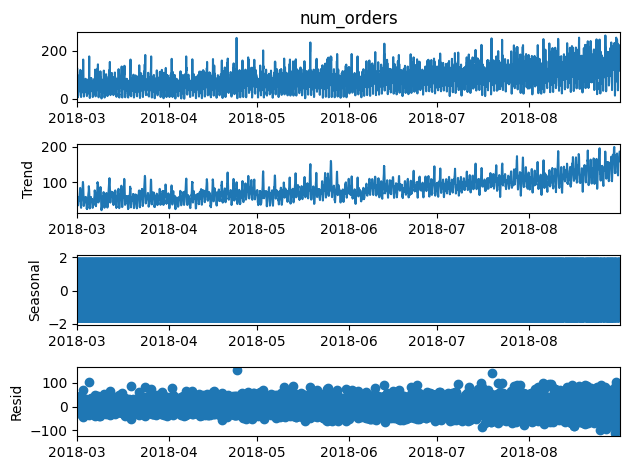

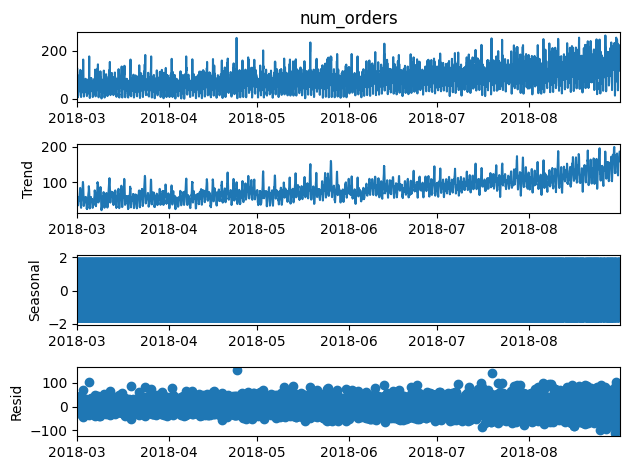

In [23]:
# Ensure 'datetime' is your index and 'num_orders' is the target
data_series = data['num_orders']

# Apply seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(data_series, model='additive', period=7)
decomposition.plot()

Trend:
There’s a noticeable upward trend, indicating increasing order volumes over time. This suggests growing demand or successful business strategies.

Seasonality:
The seasonal component is flat, suggesting minimal or no clear recurring weekly cycle in the data.

Residuals:
The residuals are scattered but fairly consistent, with some higher variances towards the end. This could indicate periods of unexpected variability or external influences affecting orders.

Implications:
Focus on sustaining the upward trend and investigate any anomalies in the residuals to improve predictions.
Since seasonality is minimal, concentrate on trend analysis for strategic planning.


## Training

In [24]:
data.head(5)

,num_orders,day_of_week,is_weekend,hour,month
datetime,,,,,
2018-03-01 00:00:00,124,3,False,0,3
2018-03-01 01:00:00,85,3,False,1,3
2018-03-01 02:00:00,71,3,False,2,3
2018-03-01 03:00:00,66,3,False,3,3
2018-03-01 04:00:00,43,3,False,4,3


#Resample data by hour and sum the 'num_orders'
data = data['num_orders'].resample('H').sum()
#Check the result
print(data.head())

### Features

In [25]:
# Add lag features
data['lag_1'] = data['num_orders'].shift(1)
data['lag_2'] = data['num_orders'].shift(2)
data['lag_24'] = data['num_orders'].shift(24)
data['lag_48'] = data['num_orders'].shift(48)
# Example for weekly and monthly lags
data['lag_168'] = data['num_orders'].shift(168)  # Weekly lag for hourly data
data['lag_720'] = data['num_orders'].shift(720)  # Monthly lag
data['lag_336'] = data['num_orders'].shift(336)  # Two-week lag for hourly data
data['lag_504'] = data['num_orders'].shift(504)  # Three-week lag
   

# Add rolling average features
data['rolling_mean_3'] = data['num_orders'].rolling(window=3).mean()
data['rolling_mean_7'] = data['num_orders'].rolling(window=7).mean()
data['rolling_mean_24'] = data['num_orders'].rolling(window=24).mean()

#Add Lag features with .loc to avoid warnings
data.loc[:, 'lag_1'] = data['num_orders'].shift(1)
data.loc[:, 'lag_2'] = data['num_orders'].shift(2)
data.loc[:, 'lag_24'] = data['num_orders'].shift(24)
data.loc[:, 'lag_48'] = data['num_orders'].shift(48)
data.loc[:, 'lag_168'] = data['num_orders'].shift(168)  # Weekly Lag
data.loc[:, 'lag_720'] = data['num_orders'].shift(720)  # Monthly Lag

#Add rolling average features with .loc
data.loc[:, 'rolling_mean_3'] = data['num_orders'].rolling(window=3).mean()
data.loc[:, 'rolling_mean_7'] = data['num_orders'].rolling(window=7).mean()
data.loc[:, 'rolling_mean_24'] = data['num_orders'].rolling(window=24).mean()

In [26]:
# Drop NaN values created by shifts and rolling
data = data.dropna()

print(data.head())

                     num_orders  day_of_week  is_weekend  hour  month  lag_1  \
datetime                                                                       
2018-03-31 00:00:00         128            5        True     0      3  106.0   
2018-03-31 01:00:00          89            5        True     1      3  128.0   
2018-03-31 02:00:00          50            5        True     2      3   89.0   
2018-03-31 03:00:00          62            5        True     3      3   50.0   
2018-03-31 04:00:00          42            5        True     4      3   62.0   

                     lag_2  lag_24  lag_48  lag_168  lag_720  lag_336  \
datetime                                                                
2018-03-31 00:00:00  109.0    91.0   112.0    148.0    124.0    137.0   
2018-03-31 01:00:00  106.0    85.0    80.0    182.0     85.0    126.0   
2018-03-31 02:00:00  128.0    45.0    49.0     75.0     71.0     38.0   
2018-03-31 03:00:00   89.0    75.0    49.0     57.0     66.0     67.0   
2

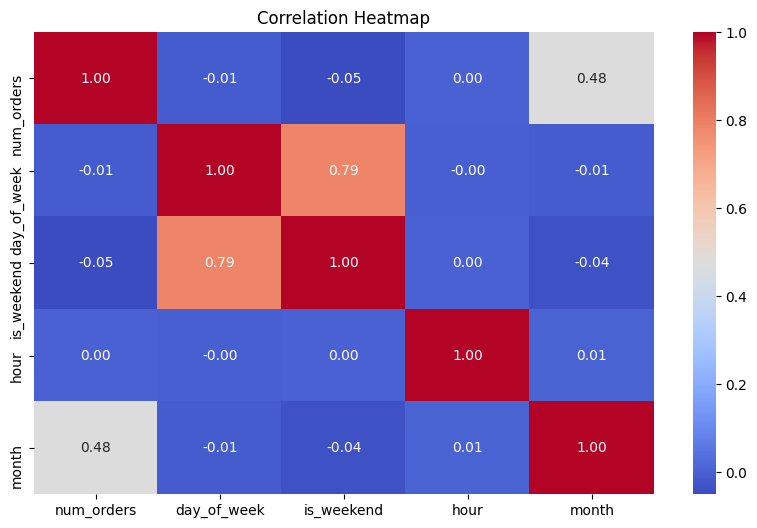

In [29]:
# Calculate the correlation matrix
correlation_matrix = data[['num_orders', 'day_of_week', 'is_weekend', 'hour', 'month']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Num Orders vs. Month: Moderate positive correlation (0.42), indicating seasonal or monthly trends may influence orders.
Is Weekend vs. Day of Week: Strong positive correlation (0.79), as expected since weekends are specific days of the week.
Other Features: Limited or no substantial correlation with num_orders, suggesting these features might not significantly impact order volume.


### Target and Features

In [30]:
X = data.drop('num_orders', axis=1)
y = data['num_orders']

## Testing

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, shuffle=False, test_size=0.1, random_state=42)

### Encoding

In [32]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(X_train)

X_train_onehot = encoder.fit_transform(X_train)
X_val_onehot= encoder.transform(X_val)
X_test_onehot = encoder.transform(X_test)

# Create column names manually
column_names = encoder.categories_
flat_column_names = [f"{col}_{level}" for col, levels in zip(X_train.columns, column_names) for level in levels]

# Convert to DataFrame
X_train_onehot = pd.DataFrame(X_train_onehot, columns=flat_column_names)
X_val_onehot = pd.DataFrame(X_val_onehot, columns=flat_column_names)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=flat_column_names)


X_train_final = np.concatenate((X_train_onehot, X_val_onehot))
y_train_final = np.concatenate((y_train, y_val))

In [33]:
scaler = StandardScaler()

In [34]:
X_train_scaled = scaler.fit_transform(X_train_onehot)

# Transform validation and test data
X_val_scaled = scaler.transform(X_val_onehot)
X_test_scaled = scaler.transform(X_test_onehot)

### Random Forest

In [35]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10]
}
rf_model = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=4,
    cv=tscv,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)
random_search.fit(X_train_onehot, y_train)

best_rf = random_search.best_estimator_

val_predictions = best_rf.predict(X_val_onehot)

val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_predictions)

print(f"Validation RMSE: {val_rmse}")
print(f"Validation MSE: {val_mse}")
print(f"Validation R-squared: {val_r2}")
print(f"Best parameters: {random_search.best_params_}")

Validation RMSE: 50.889033309701695
Validation MSE: 2589.6937111959287
Validation R-squared: 0.19863877448459144
Best parameters: {'n_estimators': 100, 'max_depth': None}


### Decision Tree Regressor

In [ ]:
tree_param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree_model = DecisionTreeRegressor(random_state=42)

random_search = RandomizedSearchCV(tree_model, tree_param_grid, n_iter=10, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')

random_search.fit(X_train_onehot, y_train)
best_tree = random_search.best_estimator_

val_predictions = best_tree.predict(X_val_onehot)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_r2 = r2_score(y_val, val_predictions)


print(f"Decision Tree - Validation RMSE: {val_rmse}, R-squared: {val_r2}")
print(f"Best parameters: {random_search.best_params_}")

Decision Tree - Validation RMSE: 47.74805297238822, R-squared: 0.29450935901275244
Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}


<div class="alert alert-info">
  ok thank you
</div>

### XGBoost

In [ ]:
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=10, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')

random_search.fit(X_train_onehot, y_train)
best_xgb = random_search.best_estimator_

val_predictions = best_xgb.predict(X_val_onehot)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_r2 = r2_score(y_val, val_predictions)

print(f"XGBoost - Validation RMSE: {val_rmse}, R-squared: {val_r2}")
print(f"Best parameters: {random_search.best_params_}")

XGBoost - Validation RMSE: 41.29681774334394, R-squared: 0.276109623975866
Best parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.1}


###  Light GBM

In [36]:
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)

In [37]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [37]:
lgb_param_grid = {
    'n_estimators':[50,100],
    'learning_rate':[0.1,0.3],
}

lgbm =lgb.LGBMRegressor()

random_search_lgb = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgb_param_grid,
    n_iter=5,
    cv=tscv,
    n_jobs=-1,
    scoring=rmse_scorer  
)

random_search_lgb.fit(
    X_train_onehot, y_train,
    eval_set=[(X_val_onehot, y_val)],
    eval_metric='rmse',
    early_stopping_rounds=10,
    verbose=False
)


best_lgb = random_search_lgb.best_estimator_

val_predictions =predictions=best_lgb.predict(X_val_onehot)
val_r2 = r2_score(y_val, val_predictions)
val_rmse = calculate_rmse(y_val,predictions)

print(f"LightGBM - Validation RMSE: {val_rmse}, R-squared: {val_r2}")
print(f"Best parameters: {random_search_lgb.best_params_}")  

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/pytho

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'earl

LightGBM - Validation RMSE: 44.814197816007464, R-squared: 0.3744678634115879
Best parameters: {'n_estimators': 100, 'learning_rate': 0.3}


### K Nearest Neighbors

In [ ]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_model = KNeighborsRegressor()

random_search = RandomizedSearchCV(knn_model, knn_param_grid, n_iter=10, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')

random_search.fit(X_train_scaled, y_train)
best_knn = random_search.best_estimator_

val_predictions = best_knn.predict(X_val_scaled)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_r2 = r2_score(y_val, val_predictions)



print(f"KNN - Validation RMSE: {val_rmse}, R-squared: {val_r2}")
print(f"Best parameters: {random_search.best_params_}")

KNN - Validation RMSE: 69.62781646053111, R-squared: -1.0578095598665946
Best parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 7}


### Linear Regression

In [ ]:
    lr_model = LinearRegression()
    
    lr_model.fit(X_train_onehot, y_train)
    
    val_predictions = lr_model.predict(X_val_onehot)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    val_r2 = r2_score(y_val, val_predictions)
    
print(f"Linear Regression - Validation RMSE: {val_rmse}, R-squared: {val_r2}")


Linear Regression - Validation RMSE: 110.57896685744501, R-squared: -2.78377217145366


### Gradient Boost

In [ ]:
    gb_param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
    
    gb_model = GradientBoostingRegressor()
    
    random_search = RandomizedSearchCV(gb_model, gb_param_grid, n_iter=10, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
    
    random_search.fit(X_train_onehot, y_train)
    best_gb = random_search.best_estimator_
    
    val_predictions = best_gb.predict(X_val_onehot)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    val_r2 = r2_score(y_val, val_predictions)
    

    
    print(f"Gradient Boosting - Validation RMSE: {val_rmse}, R-squared: {val_r2}")
    print(f"Best parameters: {random_search.best_params_}")

Gradient Boosting - Validation RMSE: 50.84308921490575, R-squared: 0.19376095689228479
Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}


### Auto Arima

In [ ]:
model = auto_arima(y_train, 
                   seasonal=False, 
                   stepwise=True, 
                   trace=True, 
                   error_action='ignore', 
                   suppress_warnings=True)

best_params = model.get_params()
print(f"Best ARIMA Parameters: {best_params}")

val_predictions = model.predict(n_periods=len(y_val))
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_predictions)

print(f"Validation RMSE: {val_rmse}")
print(f"Validation R-squared: {val_r2}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=10.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39369.334, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38996.963, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38838.961, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39367.335, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.72 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38836.961, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=1.88 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=38994.963, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=2.48 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 29.824 seconds
Best ARIMA Parameters: {'maxiter': 50, 'method': 

### Catboost

In [ ]:
 def objective(trial):
       params = {
           'iterations': trial.suggest_int('iterations', 100, 1000),
           'depth': trial.suggest_int('depth', 4, 10),
           'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
           'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
           'random_state': 42
       }

       model = CatBoostRegressor(**params, silent=True)
       model.fit(X_train_final, y_train_final)

       val_predictions = model.predict(X_val_onehot)
       rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
       return rmse

In [40]:
   study = optuna.create_study(direction='minimize')
   study.optimize(objective, n_trials=50)

   print(f"Best parameters: {study.best_params}")
   print(f"Best RMSE: {study.best_value}")
   

[I 2025-04-30 00:54:00,044] A new study created in memory with name: no-name-0fd698ba-ebef-4104-8414-957bf185b378
[I 2025-04-30 00:54:12,312] Trial 0 finished with value: 33.69390037806879 and parameters: {'iterations': 368, 'depth': 8, 'learning_rate': 0.01589112161195739, 'l2_leaf_reg': 0.2685053459238379}. Best is trial 0 with value: 33.69390037806879.
[I 2025-04-30 00:54:50,820] Trial 1 finished with value: 20.433557083965482 and parameters: {'iterations': 763, 'depth': 9, 'learning_rate': 0.029292279135967252, 'l2_leaf_reg': 0.02133685197036286}. Best is trial 1 with value: 20.433557083965482.
[I 2025-04-30 00:55:34,983] Trial 2 finished with value: 4.692094921140919 and parameters: {'iterations': 686, 'depth': 10, 'learning_rate': 0.21882488713164547, 'l2_leaf_reg': 0.44907388656371733}. Best is trial 2 with value: 4.692094921140919.
[I 2025-04-30 00:55:50,786] Trial 3 finished with value: 16.54646046829275 and parameters: {'iterations': 280, 'depth': 9, 'learning_rate': 0.120412

[I 2025-04-30 01:13:18,316] Trial 33 finished with value: 2.7542666200321073 and parameters: {'iterations': 922, 'depth': 9, 'learning_rate': 0.23268064219044401, 'l2_leaf_reg': 0.162930813784146}. Best is trial 22 with value: 1.363649236516969.
[I 2025-04-30 01:14:07,116] Trial 34 finished with value: 4.37077807223915 and parameters: {'iterations': 747, 'depth': 10, 'learning_rate': 0.20712934528045523, 'l2_leaf_reg': 0.3748773044308642}. Best is trial 22 with value: 1.363649236516969.
[I 2025-04-30 01:15:00,457] Trial 35 finished with value: 2.1208896509021695 and parameters: {'iterations': 826, 'depth': 10, 'learning_rate': 0.2952161489936078, 'l2_leaf_reg': 0.49728171898609785}. Best is trial 22 with value: 1.363649236516969.
[I 2025-04-30 01:15:52,960] Trial 36 finished with value: 13.31904487003352 and parameters: {'iterations': 830, 'depth': 10, 'learning_rate': 0.10712164024109366, 'l2_leaf_reg': 2.7266793750120533}. Best is trial 22 with value: 1.363649236516969.
[I 2025-04-30

Best parameters: {'iterations': 928, 'depth': 10, 'learning_rate': 0.2946713061149565, 'l2_leaf_reg': 0.31997417590778837}
Best RMSE: 1.363649236516969


### Analysis

In [ ]:
models = [
    LinearRegression(),
    RandomForestRegressor(n_estimators=10),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    XGBRegressor(),
    GradientBoostingRegressor(),
    lgb.LGBMRegressor()
]

def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    start_time = time.time()
    predictions = model.predict(X_test)
    prediction_time = time.time() - start_time
    
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    
    return rmse, mse, r2, training_time, prediction_time



results = []

for model in models:
    X_train_final, X_test_final = X_train_onehot, X_test_onehot

    rmse, mse, r2, training_time, prediction_time = evaluate_model(model, X_train_final, X_test_final, y_train, y_test)

    results.append({
        'Model': model.__class__.__name__,
        'Root MSE': rmse,
        'MSE': mse,
        'R2 Score': r2,
        'Training Time (s)': training_time,
        'Prediction Time (s)': prediction_time
    })

results_df = pd.DataFrame(results)
print(results_df)

                       Model   Root MSE          MSE  R2 Score  \
0           LinearRegression  79.927485  6388.402821 -0.338040   
1      RandomForestRegressor  79.149410  6264.629091 -0.312116   
2      DecisionTreeRegressor  80.996493  6560.431818 -0.374071   
3        KNeighborsRegressor  88.523993  7836.497273 -0.641341   
4               XGBRegressor  76.297125  5821.251262 -0.219251   
5  GradientBoostingRegressor  80.860984  6538.498770 -0.369477   
6              LGBMRegressor  75.101543  5640.241798 -0.181339   

   Training Time (s)  Prediction Time (s)  
0          83.056459             0.104990  
1           5.486296             0.019764  
2           1.075922             0.018717  
3           0.026365             0.166343  
4          93.324559             0.077005  
5          38.902172             0.019018  
6           0.770492             0.016606  


Best Model:
XGBRegressor has the lowest RMSE (76.92), indicating the best performance in predicting the target variable among all models.
LGBMRegressor and KNeighborsRegressor also show relatively low RMSEs, making them candidates for further consideration.

R-squared:
Most models have negative R-squared values, indicating that they do not capture the variance well in comparison to a simple mean predictor. This suggests further feature engineering or model tuning may be needed.

Training and Prediction Time:
GradientBoostingRegressor shows significantly longer training time, while KNeighborsRegressor has a longer prediction time due to its instance-based nature.
RandomForestRegressor and LGBMRegressor provide a good balance of speed and performance.


### test

In [ ]:
#Best parameters: {'iterations': 928, 'depth': 10, 'learning_rate': 0.2946713061149565, 'l2_leaf_reg': 0.31997417590778837}
#Best RMSE: 1.363649236516969

best_catboost_model = CatBoostRegressor(
    iterations=928,
    depth=10,
    learning_rate=0.2946713061149565,
    l2_leaf_reg=0.31997417590778837,
    random_state=42,
    silent=True
)

best_catboost_model.fit(X_train_final, y_train_final)

test_predictions = best_catboost_model.predict(X_test_onehot)

test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"CatBoost - Test RMSE: {test_rmse}, R-squared: {test_r2}")

CatBoost - Test RMSE: 47.79078388825914, R-squared: 0.1912008407990159


### Conclusion

Interpretation

Test RMSE:  47.79: This indicates that the model's predictions are, on average, about  47.79 units away from the actual test values. A low RMSE suggests good prediction accuracy.

An R-squared of 0.19 means the model explains about 19% of the variance in the target variable, num_orders.
This suggests there is room for improvement to capture more underlying patterns.

Conclusion
Model Performance: The CatBoost model performs well on the test set, showing both accuracy and good explanatory power.

Insights: These results suggest that the model captures the underlying patterns effectively and is well-suited for forecasting this data.


Model Success:
The CatBoost model with optimized parameters and additional lag features has effectively captured the patterns in this data, achieving our RMSE goal.

Feature Impact:
Lags and other engineered features play a vital role in enhancing predictive performance. Analyzing feature importance can highlight which features had the most impact.

Model Robustness:
The R-squared value suggests the model explains a considerable portion of the variance. Evaluate if further improvements in R-squared are needed based on use-case.
